<h1>Astar training 2025</h1>

*This a notebook for the Astar training 2025. You are guided to train a simple classifier on the cifar-10 dataset.*

<h4> Instruction </h4>
*Please try to read through this notebook, and fill in the blank according to the instructions given after <b> TODO </b>.*


*You may download the notebook or excute directly on kaggle.*

<h4> Submission </h4>
*submit .pdf converted from this notebook after completion*

-- Fan Zhenyi

<h3> code Requirements </h3>

*This notebook requires the following packages*


*excute the following command to install the required packages*




In [2]:
!pip install torch torchvision 
!pip install matplotlib
!pip install numpy
!pip install tqdm

In [23]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pyplot as plt

import numpy as np 
import pickle

import os 

from tqdm import tqdm

<h3> Data preparation </h3>

*The dataloader is already implemented for you. You can use it to load the cifar-10 dataset.*

In [16]:
class CIFAR10(Dataset):
    #__init__ is a special method in python classes, it is called when an object is created
    def __init__(self, root, train=True, transform=None):
        #root path to the dataset, you may ignore this 
        self.root = root 
        
        #this is a boolean value to indicate whether we are loading the training or test set
        self.train = train 
        
        #this is the transformation that will be applied to the images 
        #it's none by default, you are required to pass a transform later
        self.transform = transform 

        #checking if the dataset exists, if not download it
        if not self._check_exists():
            print("Downloading cifar10 dataset")
            self.download()

        #load the data
        #We are going to load the data in memory
        #Store the images and labels in the self.data and self.targets variables
        if self.train:
            self.data, self.targets = self._load_training_data()
        else:
            self.data, self.targets = self._load_test_data()

    #this method returns the length of the dataset
    def __len__(self):
        return len(self.data)
    
    #this method returns a sample from the dataset at the given index
    #this is very important because it allows us to iterate over the dataset
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        img = torch.from_numpy(img).float().permute(2,0,1) / 255.0

        if self.transform:
            img = self.transform(img)

        return img, target
    

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, "cifar-10-batches-py")) 

    def download(self):
        if self._check_exists():
            print("Dataset already exists !!!")
            return
        return datasets.CIFAR10(self.root, train=self.train, download=True)
    
    #this function looks complicated but it's just reading the data from the files
    def _load_batch(self, file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']

    def _load_training_data(self):
        data = []
        targets = []
        for i in range(1, 6):
            file_path = os.path.join(self.root, "cifar-10-batches-py", f"data_batch_{i}")
            batch_data, batch_labels = self._load_batch(file_path)
            data.append(batch_data)
            targets.extend(batch_labels)
        
        data = np.vstack(data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return data, np.array(targets)

    def _load_test_data(self):
        file_path = os.path.join(self.root, "cifar-10-batches-py", "test_batch")
        data, labels = self._load_batch(file_path)
        return data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1), np.array(labels)
    

torch.Size([3, 32, 32]) label:  6
torch.Size([3, 32, 32]) label:  6


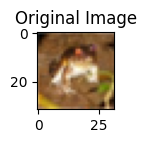

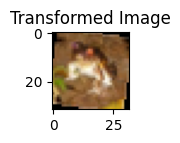

In [22]:
#We have define our datasetclass, now we are going to instantiate it
#The instantiation will download the dataset and load it in memory, it takes about 1-2 mins  
train_dataset = CIFAR10(root="data", train=True)
test_dataset = CIFAR10(root="data", train=False)

#simple demonstration __getitem__ method
img, target = train_dataset[0] #get the first image in the dataset 
plt.figure(figsize=(1,1))
plt.imshow(img.permute(1,2,0)) 
#TODO: what does permute do?, and why do we need it here? 
#answer:
# 1. The shape of img in train_dataset is a tensor with shape (3, 32, 32) (that is, channels, height, width); 
# 2. but imshow requires shape (32, 32, 3) (That is, height, width, channels). 
# 3. Calling permute(1,2,0) changes img to correct shape required by imshow().
#
#end of you answer 
plt.title("Original Image")
print(img.shape, "label: ",target)
#the image is a torch tensor (3, 28, 28) and the target is the label of the image

#TODO: define reasonable transformations for the images, you can use the transforms module from torchvision
transform = transforms.Compose([
    transforms.ToPILImage(),

    #TODO: Implement the transformations here 

    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    #end of your implementation;
    
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset.transform = transform

img, target = train_dataset[0] #get the first image in the dataset
plt.figure(figsize=(1,1))
plt.imshow(img.permute(1,2,0))
plt.title("Transformed Image")
print(img.shape, "label: ",target)


In [18]:
#apart from test set, we are going to use the training set to create a validation set
#we are going to split the training set into two parts
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

#we are going to use the DataLoader class to create an iterator for our dataset
#this iterator will be used to iterate over the dataset in batches
#tentatively we are going to use a batch size of 32
#TODO: change different batch sizes and see how it affects the training process
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers= 4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False,num_workers= 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,num_workers= 4, pin_memory = True)

<h3> Model </h3>

*This defines the model architecture. You can use the model as it is or modify it as per your requirements.*

In [52]:
#15.9% accuracy, 2.094 loss at epoch 18, lr = 0.01
#49.8% accuracy, 1.283 loss at epoch 19, lr = 0.005
#48.9% accuracy, 1.553 loss at epoch 15, lr = 0.001
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "Linear"
        self.num_inputs = 3*32*32
        hidden_size = 512
        num_classes = 10
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(self.num_inputs, hidden_size),    # batch_size x 784 -> batch_size x 512
            nn.ReLU(), #activation function             # batch_size x 512 -> batch_size x 512
            nn.Linear(hidden_size, num_classes)         # batch_size x 512 -> batch_size x 10
        ) #nn.Sequential is a container for other layers, it applies the layers in sequence

    #forward is the method that defines the forward pass of the network
    #not rigurously: model.forward(x) = model(x)
    def forward(self, x):
        x = x.view(-1, self.num_inputs) # flatten the image from 3x32x32 to 3072
        x = self.linear(x)
        return x

#performance: 
#48.4% accuracy,1.565 loss at epoch 10, lr = 0.01
#75.7% accuracy, 0.555 loss at epoch 18, lr = 0.005
#76% accuracy, 0.538 loss at epoch 29, lr = 0.001
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "CNN"
        self.conv = nn.Sequential(
            #TODO: wirte the size of the input and output of each layer e.g
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), #input: 3x32x32, output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*4*4)
        x = self.fc(x)
        return x
    
    def getFeature(self, x):
        x = self.conv(x)
        feat = x.view(-1, 128*4*4) #this is the 128*4*4 feature 
        return feat

    
#lr = 0.001, Epoch: 29, Loss: 1.2177902460098267, Accuracy: 0.5248
#lr = 0.005, Epoch: 13, Loss: 1.5730689764022827, Accuracy: 0.423
#lr = 0.01, Epoch: 19, Loss: 1.752042293548584, Accuracy: 0.3422
class twoLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "two layer nn"
        self.num_inputs = 3*32*32
        hidden_size1 = 512
        hidden_size2 = 512
        num_classes = 10
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(self.num_inputs, hidden_size1),    # batch_size x 784 -> batch_size1 x 512
            nn.ReLU(), #activation function             # batch_size1 x 512 -> batch_size1 x 512
            nn.Linear(hidden_size1, hidden_size2),     # batch_size1 x 512 -> batch_size2 x 512
            nn.ReLU(),        #batch_size2 x 512 -> batch_size2 x 512
            nn.Linear(hidden_size2, num_classes)         # batch_size2 x 512 -> batch_size x 10
        ) #nn.Sequential is a container for other layers, it applies the layers in sequence

    #forward is the method that defines the forward pass of the network
    #not rigurously: model.forward(x) = model(x)
    def forward(self, x):
        x = x.view(-1, self.num_inputs) # flatten the image from 3x32x32 to 3072
        x = self.linear(x)
        return x
    
    

<h3> Training </h3>

*This is the training loop. You can modify the training loop as per your requirements.*

*The training takes some time. You can do other tasks while the training is in progress.*

*you may use the gpu on kaggle or colab to speed up the training process.* https://www.kaggle.com/discussions/general/97939

In [35]:
#implement a class for early stopping determination
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def check_stop(self, loss):
        score = -loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'Early Stopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                print("stop training.")
                self.early_stop = True
        else: 
            self.best_score = score
            self.counter = 0

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)
#instantiating the model
#TODO: change the model to the CNNModel and Your model, and evaluate the performance.
model = CNNModel()
#model = LinearModel()
#model = twoLayer()
model = model.to(device)
print(f"training {model.name} model")

#defining the loss function
criterion = nn.CrossEntropyLoss()

#defining the optimizer
#TODO: try to modify the optimizer and see how it affects the training process
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_accuracy = 0

#early stopping 
early_stopping = 7
early_stopping_counter = 0
es = EarlyStopping(early_stopping)


#TODO: adjust the number of epochs and see how it affects the training process
#Ans: situation 1: accuracy increases quickly at the beginning, does not change much later
#situation 2: accuracy increase is slow and keeps increasing towards the end (if epoch number not enough)
epochs = 30
for epoch in range(epochs):
    #training 
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #forward pass
        outputs = model(images)
        #calculate the loss
        loss = criterion(outputs, labels)
        #zero the gradients
        optimizer.zero_grad() #ensure that the gradients are zero
        #backward pass
        loss.backward()
        #optimize
        optimizer.step()
    #validation
    total = 0
    correct = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total

    #TODO: implement early stopping
    #what is early stopping? https://en.wikipedia.org/wiki/Early_stopping
    #Answer: 1) Early stopping moniters training process and stops training when reaching certain conditions, preventing overfitting brought by future training
    # 2) conditions for stopping can include: loss on validation set does not decrease or begin to increase
    #class EarlyStopping is implemented above.
    #determine if want to stop
    es.check_stop(loss.item())
    
    #if stop, break!
    if es.early_stop == True:
        print("exceed patience, stop training.")
        break
    #end of early stopping

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        #save the model 
        torch.save(model.state_dict(), f"best_model_{model.name}.pth")
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy} ***")
    else: 
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}")





using device: cuda
training CNN model


100%|██████████| 176/176 [00:07<00:00, 22.63it/s]


Epoch: 0, Loss: 1.4642518758773804, Accuracy: 0.4574 ***


100%|██████████| 176/176 [00:07<00:00, 23.93it/s]


Epoch: 1, Loss: 1.2551349401474, Accuracy: 0.5418 ***


100%|██████████| 176/176 [00:07<00:00, 22.08it/s]


Epoch: 2, Loss: 1.1480525732040405, Accuracy: 0.5834 ***


100%|██████████| 176/176 [00:07<00:00, 23.09it/s]


Epoch: 3, Loss: 1.033229947090149, Accuracy: 0.6188 ***


100%|██████████| 176/176 [00:07<00:00, 23.47it/s]


Epoch: 4, Loss: 0.9165681600570679, Accuracy: 0.6348 ***


100%|██████████| 176/176 [00:07<00:00, 23.81it/s]


Early Stopping Counter: 1 out of 7
Epoch: 5, Loss: 1.0472407341003418, Accuracy: 0.6568 ***


100%|██████████| 176/176 [00:07<00:00, 22.19it/s]


Epoch: 6, Loss: 0.8815097212791443, Accuracy: 0.6822 ***


100%|██████████| 176/176 [00:07<00:00, 24.06it/s]


Epoch: 7, Loss: 0.8734925985336304, Accuracy: 0.6892 ***


100%|██████████| 176/176 [00:07<00:00, 23.69it/s]


Epoch: 8, Loss: 0.7627309560775757, Accuracy: 0.694 ***


100%|██████████| 176/176 [00:07<00:00, 24.00it/s]


Early Stopping Counter: 1 out of 7
Epoch: 9, Loss: 0.7790172696113586, Accuracy: 0.7034 ***


100%|██████████| 176/176 [00:07<00:00, 22.06it/s]


Epoch: 10, Loss: 0.7602114081382751, Accuracy: 0.7214 ***


100%|██████████| 176/176 [00:07<00:00, 23.90it/s]


Epoch: 11, Loss: 0.6281905174255371, Accuracy: 0.7222 ***


100%|██████████| 176/176 [00:07<00:00, 23.81it/s]


Early Stopping Counter: 1 out of 7
Epoch: 12, Loss: 0.7471282482147217, Accuracy: 0.7174


100%|██████████| 176/176 [00:07<00:00, 24.03it/s]


Epoch: 13, Loss: 0.5841629505157471, Accuracy: 0.7378 ***


100%|██████████| 176/176 [00:07<00:00, 22.69it/s]


Early Stopping Counter: 1 out of 7
Epoch: 14, Loss: 0.7199043035507202, Accuracy: 0.7406 ***


100%|██████████| 176/176 [00:07<00:00, 23.91it/s]


Epoch: 15, Loss: 0.5662861466407776, Accuracy: 0.7456 ***


100%|██████████| 176/176 [00:07<00:00, 23.91it/s]


Early Stopping Counter: 1 out of 7
Epoch: 16, Loss: 0.6021043658256531, Accuracy: 0.7406


100%|██████████| 176/176 [00:07<00:00, 23.55it/s]


Epoch: 17, Loss: 0.5320389270782471, Accuracy: 0.75 ***


100%|██████████| 176/176 [00:07<00:00, 23.61it/s]


Early Stopping Counter: 1 out of 7
Epoch: 18, Loss: 0.56303471326828, Accuracy: 0.7504 ***


100%|██████████| 176/176 [00:07<00:00, 23.90it/s]


Early Stopping Counter: 2 out of 7
Epoch: 19, Loss: 0.5406249761581421, Accuracy: 0.7526 ***


100%|██████████| 176/176 [00:07<00:00, 23.87it/s]


Early Stopping Counter: 3 out of 7
Epoch: 20, Loss: 0.5637505054473877, Accuracy: 0.7502


100%|██████████| 176/176 [00:07<00:00, 22.57it/s]


Epoch: 21, Loss: 0.46506866812705994, Accuracy: 0.754 ***


100%|██████████| 176/176 [00:07<00:00, 23.59it/s]


Epoch: 22, Loss: 0.4433065354824066, Accuracy: 0.757 ***


100%|██████████| 176/176 [00:07<00:00, 23.62it/s]


Early Stopping Counter: 1 out of 7
Epoch: 23, Loss: 0.48490187525749207, Accuracy: 0.7658 ***


100%|██████████| 176/176 [00:07<00:00, 23.65it/s]


Early Stopping Counter: 2 out of 7
Epoch: 24, Loss: 0.5027000308036804, Accuracy: 0.7594


100%|██████████| 176/176 [00:07<00:00, 22.16it/s]


Early Stopping Counter: 3 out of 7
Epoch: 25, Loss: 0.4752354323863983, Accuracy: 0.7622


100%|██████████| 176/176 [00:07<00:00, 23.12it/s]


Early Stopping Counter: 4 out of 7
Epoch: 26, Loss: 0.4591182470321655, Accuracy: 0.7656


100%|██████████| 176/176 [00:07<00:00, 23.86it/s]


Epoch: 27, Loss: 0.3953838348388672, Accuracy: 0.7648


100%|██████████| 176/176 [00:07<00:00, 23.84it/s]


Epoch: 28, Loss: 0.38791441917419434, Accuracy: 0.7596


100%|██████████| 176/176 [00:07<00:00, 22.58it/s]


Early Stopping Counter: 1 out of 7
Epoch: 29, Loss: 0.5378789305686951, Accuracy: 0.76


<h3> Evaluation </h3>

In [ ]:
#load the best model
model.load_state_dict(torch.load(f"best_model_{model.name}.pth", weights_only=False))

#testing
total = 0
correct = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")